"""
# Model Development

This notebook develops and tunes the machine learning models for:
- Anomaly Detection
- Sentiment Analysis
- Risk Scoring
- Trend Analysis
"""

### 1. Setup


In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
from models.anomaly_detector import HybridAnomalyDetector
from models.sentiment_engine import SentimentAnalyzer
from models.risk_scorer import BayesianRiskScorer
from models.trend_analyzer import TrendAnalyzer
from preprocessing.feature_extractor import AdvancedFeatureExtractor

print("✓ Imports successful")

✓ Imports successful


### 2. Generate Synthetic Training Data


In [3]:
def generate_training_data(n_samples=1000):
    """Generate synthetic data for model training"""
    np.random.seed(42)
    
    # Normal data
    X_normal = np.random.randn(int(n_samples * 0.9), 10)
    
    # Anomalies (10%)
    X_anomalies = np.random.randn(int(n_samples * 0.1), 10) * 3 + 5
    
    # Combine
    X = np.vstack([X_normal, X_anomalies])
    y = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])
    
    # Shuffle
    indices = np.random.permutation(len(X))
    X, y = X[indices], y[indices]
    
    return X, y

X_train, y_train = generate_training_data()
print(f"✓ Generated {len(X_train)} training samples")
print(f"  Normal: {(y_train == 0).sum()}")
print(f"  Anomalies: {(y_train == 1).sum()}")

✓ Generated 1000 training samples
  Normal: 900
  Anomalies: 100


### 3. Anomaly Detection Model


TRAINING ANOMALY DETECTOR



✓ Model trained
Detected anomalies: 100
Score range: [0.172, 5.766]


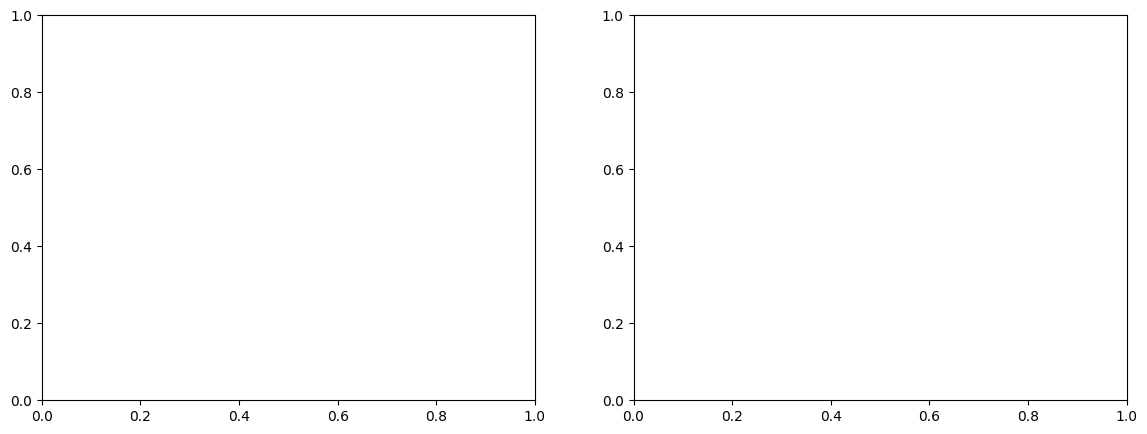

In [4]:
print("\n" + "="*60)
print("TRAINING ANOMALY DETECTOR")
print("="*60)

# Initialize and train
detector = HybridAnomalyDetector(contamination=0.1, n_estimators=100)
detector.fit(X_train)

# Predict
predictions = detector.predict(X_train)
scores = detector.predict(X_train, return_scores=True)

print(f"\n✓ Model trained")
print(f"Detected anomalies: {predictions.sum()}")
print(f"Score range: [{scores.min():.3f}, {scores.max():.3f}]")

# Visualize scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

In [5]:
# Score distribution
axes[0].hist(scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.percentile(scores, 90), color='red', linestyle='--', 
                label='90th percentile (threshold)')
axes[0].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

In [6]:
# Scores over samples
axes[1].scatter(range(len(scores)), scores, c=predictions, 
                cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1].set_title('Anomaly Scores Across Samples', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Anomaly Score')
axes[1].axhline(np.percentile(scores, 90), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(Path.cwd().parent / 'data' / 'processed' / 'anomaly_scores.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

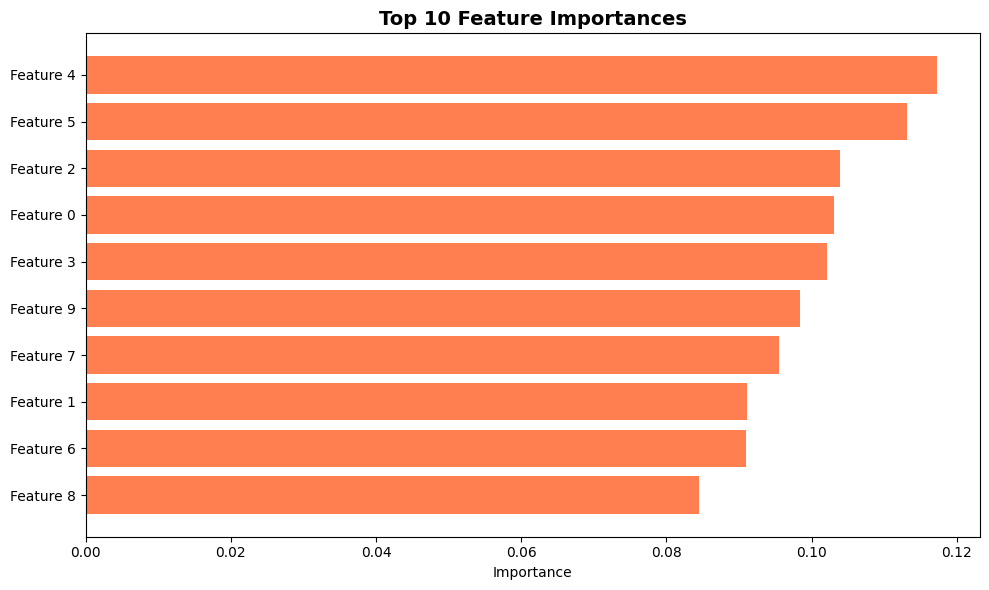


✓ Feature importance calculated


In [7]:
# Feature importance
if detector.feature_importance_ is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    feature_names = [f'Feature {i}' for i in range(len(detector.feature_importance_))]
    importance_sorted = sorted(zip(feature_names, detector.feature_importance_), 
                               key=lambda x: x[1], reverse=True)
    
    features, importances = zip(*importance_sorted[:10])
    
    ax.barh(range(len(features)), importances, color='coral')
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    ax.set_xlabel('Importance')
    ax.set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Feature importance calculated")

### 4. Sentiment Analysis Model

In [8]:
print("\n" + "="*60)
print("TESTING SENTIMENT ANALYZER")
print("="*60)

analyzer = SentimentAnalyzer()


TESTING SENTIMENT ANALYZER


In [9]:
print("\n" + "="*60)
print("TESTING SENTIMENT ANALYZER (sample run)")
print("="*60)

# Run a small batch of sample texts and store results so later cells can display them
results = []
sample_texts = [
    'Excellent economic growth and tourism boom!',
    'Crisis deepens as fuel shortage continues',
    'Government announces new infrastructure project',
    'Power cuts cause disruption to businesses'
]
for text in sample_texts:
    scores = analyzer.analyze_text(text)
    label = analyzer.get_sentiment_label(scores)
    confidence = max(scores.get('positive',0), scores.get('neutral',0), scores.get('negative',0))
    results.append({'text': text, 'label': label, 'confidence': confidence, 'scores': scores})

print(f'✓ Sample sentiment analysis complete. {len(results)} results stored in `results`.')


TESTING SENTIMENT ANALYZER (sample run)
✓ Sample sentiment analysis complete. 4 results stored in `results`.


In [10]:
# Display results
print("\nSentiment Analysis Results:")
print("-" * 80)
for i, result in enumerate(results, 1):
    print(f"\n{i}. Text: {result['text']}")
    print(f"   Label: {result['label'].upper()}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Scores: Pos={result['scores']['positive']:.2f}, "
          f"Neu={result['scores']['neutral']:.2f}, Neg={result['scores']['negative']:.2f}")



Sentiment Analysis Results:
--------------------------------------------------------------------------------

1. Text: Excellent economic growth and tourism boom!
   Label: POSITIVE
   Confidence: 66.67%
   Scores: Pos=0.33, Neu=0.67, Neg=0.00

2. Text: Crisis deepens as fuel shortage continues
   Label: NEGATIVE
   Confidence: 66.67%
   Scores: Pos=0.00, Neu=0.67, Neg=0.33

3. Text: Government announces new infrastructure project
   Label: NEUTRAL
   Confidence: 100.00%
   Scores: Pos=0.00, Neu=1.00, Neg=0.00

4. Text: Power cuts cause disruption to businesses
   Label: NEUTRAL
   Confidence: 100.00%
   Scores: Pos=0.00, Neu=1.00, Neg=0.00


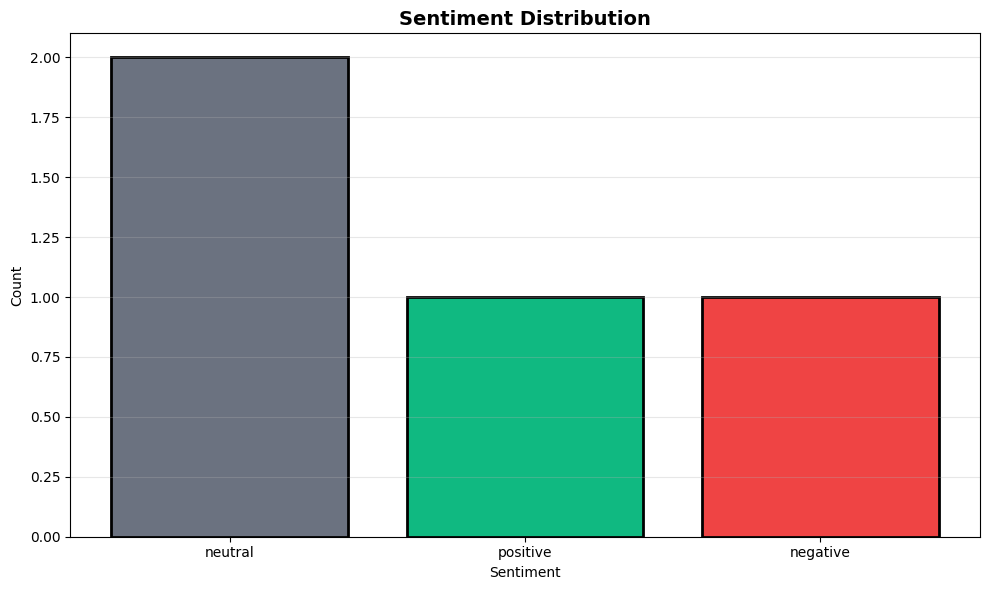


✓ Sentiment analysis tested


In [11]:
# Visualize sentiment distribution
fig, ax = plt.subplots(figsize=(10, 6))

labels = [r['label'] for r in results]
label_counts = pd.Series(labels).value_counts()

colors = {'positive': '#10B981', 'neutral': '#6B7280', 'negative': '#EF4444'}
bar_colors = [colors.get(label, 'gray') for label in label_counts.index]

ax.bar(label_counts.index, label_counts.values, color=bar_colors, edgecolor='black', linewidth=2)
ax.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Sentiment analysis tested")

### 5. Risk Scoring Model

In [12]:
print("\n" + "="*60)
print("TESTING RISK SCORER")
print("="*60)

risk_scorer = BayesianRiskScorer()



TESTING RISK SCORER


In [13]:
# Test scenarios
scenarios = [
    {
        'name': 'High Risk Scenario',
        'sentiment_score': -0.8,
        'sentiment_volatility': 0.6,
        'time_series_values': np.random.randn(100) * 3 + 10,
        'trend_slope': -0.5,
        'trend_strength': 0.9,
        'anomaly_score': 0.85,
        'source_credibility': 0.9,
        'timestamp': pd.Timestamp.now()
    },
    {
        'name': 'Low Risk Scenario',
        'sentiment_score': 0.6,
        'sentiment_volatility': 0.2,
        'time_series_values': np.random.randn(100) * 0.5 + 5,
        'trend_slope': 0.2,
        'trend_strength': 0.7,
        'anomaly_score': 0.15,
        'source_credibility': 0.95,
        'timestamp': pd.Timestamp.now()
    },
    {
        'name': 'Medium Risk Scenario',
        'sentiment_score': -0.3,
        'sentiment_volatility': 0.4,
        'time_series_values': np.random.randn(100) * 2 + 7,
        'trend_slope': -0.2,
        'trend_strength': 0.5,
        'anomaly_score': 0.5,
        'source_credibility': 0.8,
        'timestamp': pd.Timestamp.now()
    }
]

In [14]:
# Assess each scenario
assessments = []
for scenario in scenarios:
    assessment = risk_scorer.assess_risk(scenario)
    assessments.append({
        'name': scenario['name'],
        'score': assessment.overall_score,
        'level': assessment.risk_level.value,
        'confidence': assessment.confidence
    })
    
    print(f"\n{scenario['name']}:")
    print(f"  Risk Score: {assessment.overall_score:.2%}")
    print(f"  Risk Level: {assessment.risk_level.value.upper()}")
    print(f"  Confidence: {assessment.confidence:.2%}")
    print(f"  Top Recommendation: {assessment.recommendations[0]}")


High Risk Scenario:
  Risk Score: 70.07%
  Risk Level: HIGH
  Confidence: 100.00%
  Top Recommendation: ⚠️ Immediate attention required

Low Risk Scenario:
  Risk Score: 22.15%
  Risk Level: LOW
  Confidence: 100.00%
  Top Recommendation: ✅ Situation stable

Medium Risk Scenario:
  Risk Score: 59.05%
  Risk Level: MEDIUM
  Confidence: 100.00%
  Top Recommendation: ⚡ Moderate concern - stay vigilant


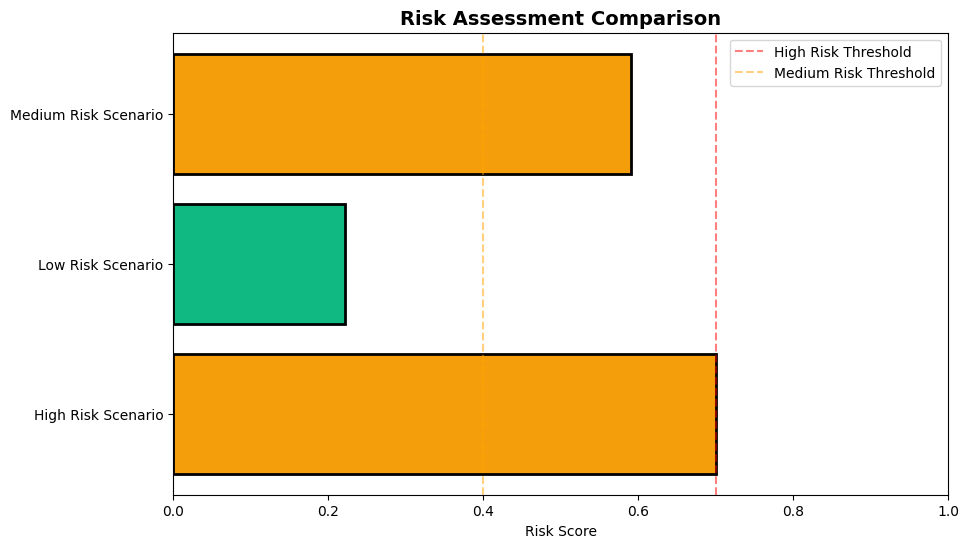

In [15]:
# Visualize risk assessments
fig, ax = plt.subplots(figsize=(10, 6))

names = [a['name'] for a in assessments]
scores = [a['score'] for a in assessments]
colors_map = {'critical': '#EF4444', 'high': '#F59E0B', 'medium': '#F59E0B', 'low': '#10B981'}
bar_colors = [colors_map.get(a['level'], 'gray') for a in assessments]

bars = ax.barh(names, scores, color=bar_colors, edgecolor='black', linewidth=2)
ax.set_xlim(0, 1)
ax.set_xlabel('Risk Score')
ax.set_title('Risk Assessment Comparison', fontsize=14, fontweight='bold')
ax.axvline(0.7, color='red', linestyle='--', alpha=0.5, label='High Risk Threshold')
ax.axvline(0.4, color='orange', linestyle='--', alpha=0.5, label='Medium Risk Threshold')
ax.legend()

In [16]:
# Add value labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.02, i, f'{score:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(Path.cwd().parent / 'data' / 'processed' / 'risk_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Risk scoring tested")

<Figure size 640x480 with 0 Axes>


✓ Risk scoring tested


### 6. Trend Analysis Model

In [17]:
print("\n" + "="*60)
print("TESTING TREND ANALYZER")
print("="*60)

trend_analyzer = TrendAnalyzer()



TESTING TREND ANALYZER


In [18]:
# Generate time series with trend
t = np.arange(100)
trend_component = 0.5 * t
seasonal_component = 10 * np.sin(2 * np.pi * t / 7)
noise = np.random.randn(100) * 3
values = trend_component + seasonal_component + noise + 50


In [19]:
# Detect trend
trend_info = trend_analyzer.detect_trend(values)
print(f"\nTrend Detection:")
print(f"  Direction: {trend_info['direction']}")
print(f"  Slope: {trend_info['slope']:.3f}")
print(f"  Strength (R²): {trend_info['r_squared']:.3f}")
print(f"  P-value: {trend_info['p_value']:.4f}")


Trend Detection:
  Direction: increasing
  Slope: 0.481
  Strength (R²): 0.779
  P-value: 0.0000


In [20]:
# Decomposition
decomp = trend_analyzer.decompose_time_series(values, period=7)
print(f"\nTime Series Decomposition:")
print(f"  Trend strength: {decomp['trend_strength']:.3f}")
print(f"  Seasonal strength: {decomp['seasonal_strength']:.3f}")


Time Series Decomposition:
  Trend strength: 0.836
  Seasonal strength: 0.219


In [21]:
# Forecast
forecast_result = trend_analyzer.forecast_simple(values, periods=14)
print(f"\n14-Period Forecast:")
print(f"  Method: {forecast_result['method']}")
print(f"  Next values: {forecast_result['forecast'][:3]}")


14-Period Forecast:
  Method: linear
  Next values: [ 99.21952971  99.70073356 100.18193741]


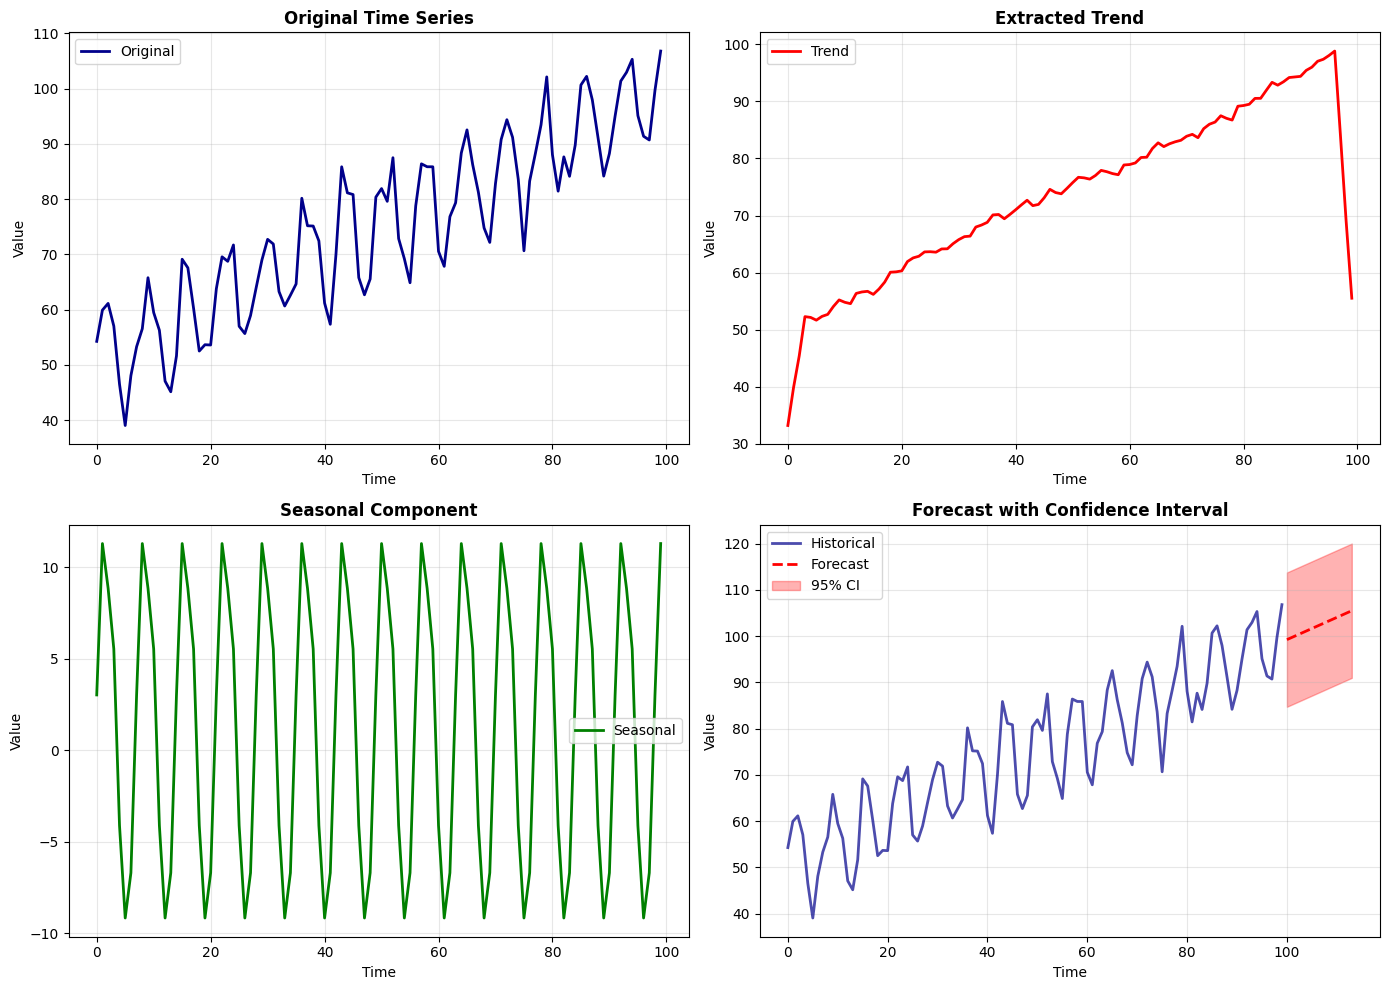


✓ Trend analysis tested


In [22]:
# Visualize trend analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original series
axes[0, 0].plot(values, linewidth=2, color='darkblue', label='Original')
axes[0, 0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Trend component
axes[0, 1].plot(decomp['trend'], linewidth=2, color='red', label='Trend')
axes[0, 1].set_title('Extracted Trend', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Seasonal component
axes[1, 0].plot(decomp['seasonal'], linewidth=2, color='green', label='Seasonal')
axes[1, 0].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Forecast
forecast_x = np.arange(len(values), len(values) + len(forecast_result['forecast']))
axes[1, 1].plot(values, linewidth=2, color='darkblue', label='Historical', alpha=0.7)
axes[1, 1].plot(forecast_x, forecast_result['forecast'], linewidth=2, 
                color='red', linestyle='--', label='Forecast')
axes[1, 1].fill_between(forecast_x, 
                         forecast_result['lower_bound'], 
                         forecast_result['upper_bound'],
                         alpha=0.3, color='red', label='95% CI')
axes[1, 1].set_title('Forecast with Confidence Interval', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path.cwd().parent / 'data' / 'processed' / 'trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Trend analysis tested")

### 7. Model Performance Summary

In [23]:
print("\n" + "="*60)
print("MODEL DEVELOPMENT SUMMARY")
print("="*60)

summary = {
    'anomaly_detection': {
        'algorithm': 'Hybrid Ensemble (Isolation Forest + Density + PCA)',
        'contamination': 0.1,
        'n_estimators': 100,
        'score_range': [float(np.min(scores)), float(np.max(scores))],
        'detected_anomalies': int(np.sum(predictions))
    },
    'sentiment_analysis': {
        'model': 'Rule-based with lexicon',
        'supported_languages': ['English', 'Sinhala', 'Tamil'],
        'output': 'Positive/Neutral/Negative + Confidence'
    },
    'risk_scoring': {
        'method': 'Bayesian with Beta-Binomial conjugate prior',
        'components': 6,
        'output': 'Score (0-1) + Level + Recommendations'
    },
    'trend_analysis': {
        'methods': ['Linear regression', 'Decomposition', 'Forecasting'],
        'forecast_horizon': '14 periods',
        'includes_confidence_interval': True
    }
}

import json
summary_path = Path.cwd().parent / 'data' / 'processed' / 'model_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\nModel Components:")
print("  \u2713 Anomaly Detection: Hybrid ensemble")
print("  \u2713 Sentiment Analysis: Multi-lingual")
print("  \u2713 Risk Scoring: Bayesian framework")
print("  \u2713 Trend Analysis: Decomposition + Forecast")
print(f"\nSummary saved to: {summary_path}")
print("="*60)



MODEL DEVELOPMENT SUMMARY

Model Components:
  ✓ Anomaly Detection: Hybrid ensemble
  ✓ Sentiment Analysis: Multi-lingual
  ✓ Risk Scoring: Bayesian framework
  ✓ Trend Analysis: Decomposition + Forecast

Summary saved to: c:\Users\WW\Documents\modelX final round try 2\data\processed\model_summary.json


### 8. Save Trained Models

In [24]:
from config import MODELS_DIR

# Save anomaly detector
detector.save(MODELS_DIR / 'anomaly_detector.pkl')
print(f"✓ Saved anomaly detector to: {MODELS_DIR / 'anomaly_detector.pkl'}")

print("\n🎉 Model development complete! Ready for evaluation.")

✓ Saved anomaly detector to: c:\Users\WW\Documents\modelX final round try 2\data\models\anomaly_detector.pkl

🎉 Model development complete! Ready for evaluation.
